In [1]:
from halos import Catalog, Cosmo
from astropy.cosmology import LambdaCDM, z_at_value
import matplotlib.pyplot as plt
import healpy as hp
import numpy as np
import astropy.units as u
from scipy.interpolate import make_interp_spline

h_Hubble = 0.67

%matplotlib inline

## Redshift computation

One of the most computationally expensive operations is the calculation of the halo redshift given the comoving distance. This calculation can be performed using the `z_at_value` function from Astropy, with the cosmological parameters correctly set. By analyzing the information from the shells, which provide both the redshift and the comoving distance at the start and end of the shells, it was observed that when setting the cosmological parameters to match the simulation values, and using the `z_at_value` function or calculating the redshift independently, a discrepancy arises between the values obtained from the simulation and those calculated. Therefore, it was decided to correct the values calculated with `z_at_value` by applying a correction factor, which depends on the redshift. The correction factor is obtained through a cubic spline interpolation of the known points from the shells.




In [2]:
cosmo = Cosmo()
D = np.concatenate((cosmo.data['distance'], cosmo.data['xend']))
red = np.concatenate((cosmo.data['z'], cosmo.data['zend']))

# Ordinamento
sorted_indices = np.argsort(red)
z_sorted = red[sorted_indices]
distance_sorted = D[sorted_indices]

# Rimuovere duplicati
unique_z, unique_indices = np.unique(z_sorted, return_index=True)
unique_distance = distance_sorted[unique_indices]

# spline
distance2redshift = make_interp_spline(unique_distance, unique_z, k = 3)
correction = make_interp_spline(cosmo.data['z'][1:], cosmo.data['z_correction'][1:], k = 3)
distance2redshift_linear = make_interp_spline(unique_distance, unique_z, k = 1)
correction_linear = make_interp_spline(cosmo.data['z'][1:], cosmo.data['z_correction'][1:], k = 1)

# Creazione dati
z_values = np.linspace(0, 100, 1000)
d_values = np.linspace(1e4, 8.6e6, 3000)

/opt/miniconda3/lib/python3.12/site-packages/scipy/optimize/_optimize.py:2972: RuntimeWarning: overflow encountered in scalar divide
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom


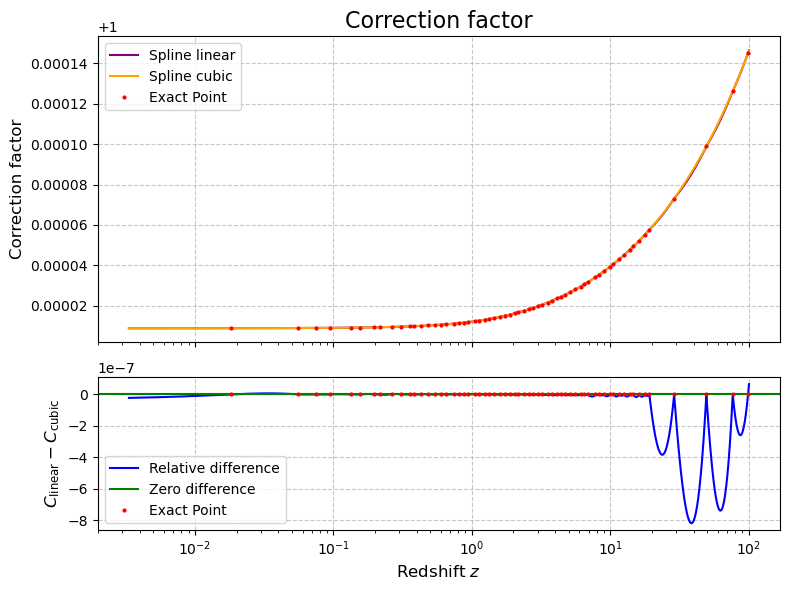

In [3]:
redshift = z_at_value(cosmo.cosmo.comoving_distance, d_values * u.kpc / h_Hubble, zmin = 0, zmax = 5000)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6), sharex=True, gridspec_kw={"height_ratios": [2, 1]})

# Primo grafico: Fattore di correzione
ax1.plot(redshift, correction_linear(redshift), color="purple", label="Spline linear")
ax1.plot(redshift, correction(redshift), color="orange", label="Spline cubic")
ax1.plot(cosmo.data['z'][1:], cosmo.data['z_correction'][1:], marker="o", markersize=2, linestyle="None", color="red", label="Exact Point")
ax1.set_title("Correction factor", fontsize=16)
ax1.set_ylabel("Correction factor", fontsize=12)
ax1.set_xscale("log")
ax1.grid(True, linestyle='--', alpha=0.7)
ax1.legend(fontsize=10)

# Secondo grafico: Differenza relativa
difference = (correction_linear(redshift) - correction(redshift))
ax2.plot(redshift, difference, color="blue", label="Relative difference")
ax2.axhline(0, color='green', linestyle='-', label='Zero difference')
plt.plot(cosmo.data['z'][1:], np.zeros_like(cosmo.data['z'][1:]), marker="o", markersize=2, linestyle="None", color="red", label="Exact Point")
ax2.set_xlabel("Redshift $z$", fontsize=12)
ax2.set_ylabel(r"$C_{\rm linear} - C_{\rm cubic}$", fontsize=12)
ax2.grid(True, linestyle="--", alpha=0.7)
ax2.legend(fontsize=10)

# Adattamento layout
plt.tight_layout()
plt.show()



The curve obtained from `z_at_value` multiplied by the correction factor was then considered the exact theoretical curve. However, this method for calculating the redshift given the comoving distance is not suitable for processing a large number of halos. For this reason, spline interpolation was also used to calculate the redshift from the comoving distance. In the graph below, it is shown that the error introduced by this approximation is always smaller than $0.2\%$.

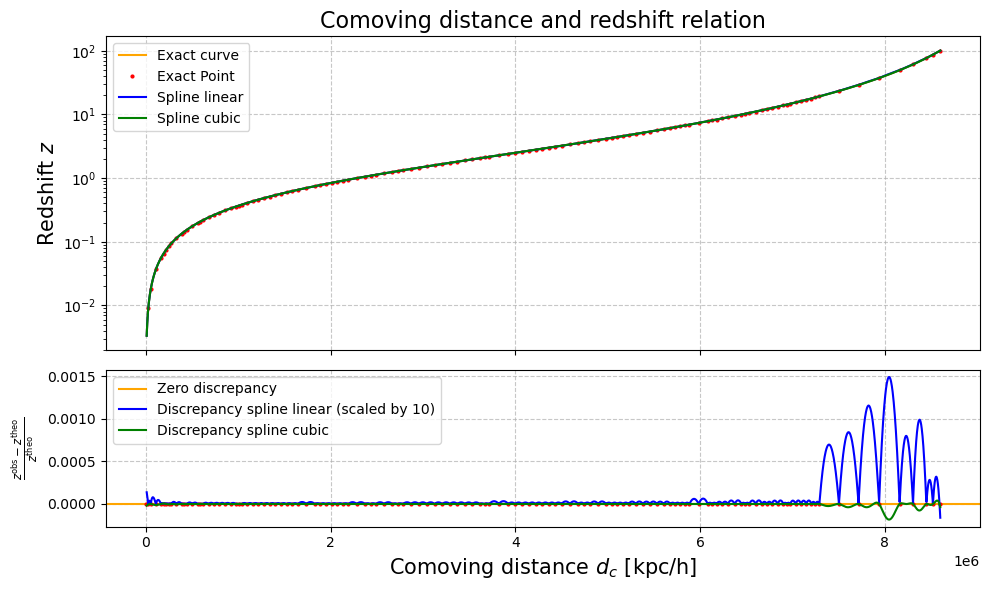

In [4]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6), sharex=True, gridspec_kw={"height_ratios": [2, 1]})

# Primo grafico: Redshift vs Comoving distance
ax1.plot(d_values, redshift * correction(redshift), color="orange", label="Exact curve")
ax1.plot(unique_distance, unique_z, marker="o", markersize=2, linestyle="None", color="red", label="Exact Point")
ax1.plot(d_values, distance2redshift_linear(d_values), linestyle="-", color="blue", label="Spline linear")
ax1.plot(d_values, distance2redshift(d_values), linestyle="-", color="green", label="Spline cubic")
ax1.set_ylabel('Redshift $z$', fontsize=15)
ax1.set_yscale('log')

ax1.grid(True, linestyle='--', alpha=0.7)
ax1.legend(fontsize=10)
ax1.set_title('Comoving distance and redshift relation', fontsize=16)

# Secondo grafico: Discrepanza relativa
discrepancy = (distance2redshift(d_values) - (redshift * correction(redshift))) / (redshift * correction(redshift))
discrepancy_linear = (distance2redshift_linear(d_values) - (redshift * correction(redshift))) / (redshift * correction(redshift))

ax2.axhline(0, color='orange', linestyle='-', label='Zero discrepancy')
ax2.plot(unique_distance, np.zeros_like(unique_distance), linestyle='None', color="red", marker="o", markersize=2)

ax2.plot(d_values, discrepancy_linear/10, linestyle='-', color='blue', label='Discrepancy spline linear (scaled by 10)')
ax2.plot(d_values, discrepancy, linestyle='-', color='green', label='Discrepancy spline cubic')
ax2.set_xlabel('Comoving distance $d_c$ [kpc/h]', fontsize=15)

ax2.set_ylabel(r'$\frac{z^{\rm obs} - z^{\rm theo}}{z^{\rm theo}}$', fontsize=12)
ax2.grid(True, linestyle='--', alpha=0.7)
ax2.legend(fontsize=10)


# Adattamento layout
plt.tight_layout()
plt.show()


## Halos

I create two plots showing the distribution of halos in shells. The first plot is a 3D plot showing the spatial positions, while the second one ignores the azimuthal coordinate to better show that the halos lie within two concentric shells.

In [5]:
snapshot_number = 60
mass_inf = 1e3

In [6]:
info = Cosmo()
catalog = Catalog(snapshot_number)

print(f"Numer of halos: {catalog.get_n_halos()}")
catalog_selection = catalog.select_mass_above(mass_inf)
print(f"Number of halos (M>1e3): {catalog_selection.get_n_halos()}")
del catalog
catalog_selection.compute_all()

Reading AllSkyMock_snap_060_0.bin0...
Reading AllSkyMock_snap_060_1.bin0...
Reading AllSkyMock_snap_060_2.bin0...
Reading AllSkyMock_snap_060_3.bin0...
Numer of halos: 45050
Number of halos (M>1e3): 8229
-------------- (np.float64(0.0), 62) --------------
Reading KappaMap_snap_062.DM.seed_100672.fits...
Calculating convergence contribution from KappaMap_snap_062.DM.seed_100672.fits... 

-------------- (np.float64(0.01815), 61) --------------
Reading KappaMap_snap_061.DM.seed_100672.fits...
Calculating convergence contribution from KappaMap_snap_061.DM.seed_100672.fits... 

-------------- (np.float64(0.05545), 60) --------------
Reading KappaMap_snap_060.DM.seed_100672.fits...
Calculating convergence contribution from KappaMap_snap_060.DM.seed_100672.fits... 



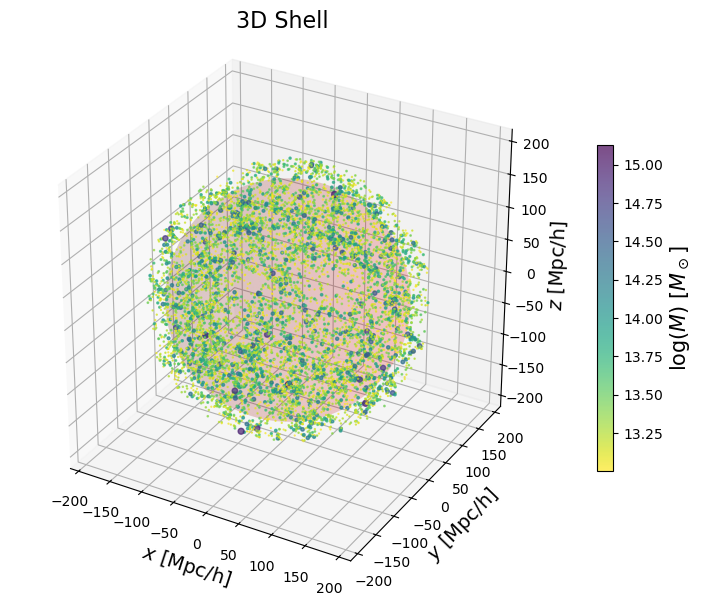

In [7]:
# Definisci il raggio della sfera
raggio = info.from_snapshot_get(snapshot_number, 'distance')/10**3

# Crea gli angoli sferici (theta, phi)
theta = np.linspace(0, 2 * np.pi, 100)  # Angolo azimutale
phi = np.linspace(0, np.pi, 100)        # Angolo zenitale

# Creare una griglia di punti sferici
theta, phi = np.meshgrid(theta, phi)

# Converti le coordinate sferiche in cartesiane
x_sfera = raggio * np.sin(phi) * np.cos(theta)
y_sfera = raggio * np.sin(phi) * np.sin(theta)
z_sfera = raggio * np.cos(phi)

# Crea il plot 3D
fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot dei dati degli aloni
sc = ax.scatter(catalog_selection.pos_x/10**3,
                catalog_selection.pos_y/10**3,
                catalog_selection.pos_z/10**3,
                c=10 + np.log10(catalog_selection.mass), 
                cmap='viridis_r', 
                s=0.00005 * np.log10(catalog_selection.mass)**8,
                alpha=0.7)

# Aggiungi una barra colori per rappresentare la massa
cb = plt.colorbar(sc, ax=ax, shrink=0.6)
cb.set_label(rf'$\log(M)$ [$M_\odot$]', fontsize=15)

# Configura gli assi
ax.set_xlabel(r'$x$ [Mpc/h]', fontsize=14)
ax.set_ylabel(r'$y$ [Mpc/h]', fontsize=14)
ax.set_zlabel(r'$z$ [Mpc/h]', fontsize=14)
ax.set_title('3D Shell', fontsize=16)

# Imposta la stessa unità per tutti gli assi (distanza uguale su tutti gli assi)
ax.set_box_aspect([1, 1, 1])  # Impostazione uguale per tutti gli assi

# Traccia la sfera
ax.plot_surface(x_sfera, y_sfera, z_sfera, color='r', alpha=0.1)

# Ottimizzazione della disposizione e degli spazi
plt.tight_layout()

# Mostra il grafico
plt.show()


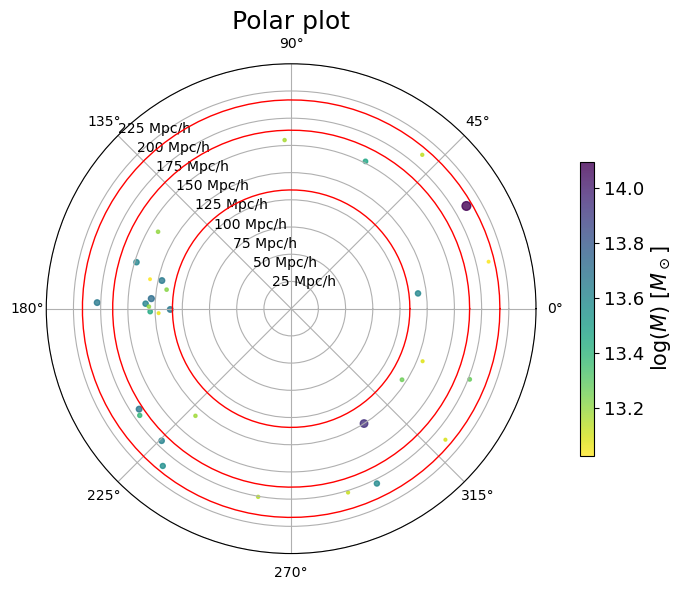

In [8]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(9, 6))  # Dimensioni aumentate
mask = (catalog_selection.theta < 0.1) & (catalog_selection.theta > 0.01)
# Scatter plot: posizione degli aloni nel piano (distanza vs angolo azimutale)
sc = ax.scatter(catalog_selection.phi[mask], catalog_selection.distance[mask]/(10**3), 
                c=10 + np.log10(catalog_selection.mass[mask]), 
                cmap='viridis_r', 
                s=0.0005 * np.log10(catalog_selection.mass[mask])**8, 
                alpha=0.8)

# Aggiungi cerchi con raggi specifici
radii = [info.from_snapshot_get(snapshot_number, 'xstart')/(10**3),
         info.from_snapshot_get(snapshot_number, 'distance')/(10**3),
         info.from_snapshot_get(snapshot_number, 'xend')/(10**3)]

for radius in radii:
    ax.plot(np.linspace(0, 2 * np.pi, 100), np.full(100, radius), 
            lw=1, color='red')

# Barra colori
cb = plt.colorbar(sc, ax=ax, shrink=0.6)
cb.set_label(rf'$\log(M)$ [$M_\odot$]', fontsize=15)
cb.ax.tick_params(labelsize=13)

# Configurazione degli assi
ax.set_title('Polar plot', fontsize=18)

# Modifica dei label per coordinate polari
ax.set_rlabel_position(135)


ax.set_rticks([25, 50, 75, 100, 125, 150, 175, 200, 225])
ax.set_yticklabels([f"{r} Mpc/h" for r in [25, 50, 75, 100, 125, 150, 175, 200, 225]])


plt.tight_layout()
plt.show()


Now I use the known data to calculate the luminosity distance corrected according to Bertacca and create two Mollview plots.

In [9]:
snapshot_number = 40
mass_inf = 1e3
n_side = 4096
n_pix = hp.nside2npix(n_side)

catalog = Catalog(snapshot_number)
print(f"Numer of halos: {catalog.get_n_halos()}")
catalog_selection = catalog.select_mass_above(mass_inf)
print(f"Number of halos (M>1e3): {catalog_selection.get_n_halos()} \n")
del catalog
catalog_selection.compute_all(n_side=n_side)

/opt/miniconda3/lib/python3.12/site-packages/scipy/optimize/_optimize.py:2972: RuntimeWarning: overflow encountered in scalar divide
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom


Reading AllSkyMock_snap_040_0.bin0...
Reading AllSkyMock_snap_040_1.bin0...
Reading AllSkyMock_snap_040_2.bin0...
Reading AllSkyMock_snap_040_3.bin0...
Numer of halos: 14517825
Number of halos (M>1e3): 1958848 

-------------- (np.float64(0.0), 62) --------------
Reading KappaMap_snap_062.DM.seed_100672.fits...
Calculating convergence contribution from KappaMap_snap_062.DM.seed_100672.fits... 

-------------- (np.float64(0.01815), 61) --------------
Reading KappaMap_snap_061.DM.seed_100672.fits...
Calculating convergence contribution from KappaMap_snap_061.DM.seed_100672.fits... 

-------------- (np.float64(0.05545), 60) --------------
Reading KappaMap_snap_060.DM.seed_100672.fits...
Calculating convergence contribution from KappaMap_snap_060.DM.seed_100672.fits... 

-------------- (np.float64(0.07461), 59) --------------
Reading KappaMap_snap_059.DM.seed_100672.fits...
Calculating convergence contribution from KappaMap_snap_059.DM.seed_100672.fits... 

-------------- (np.float64(0.094

Same pixel encountered 14327 times.


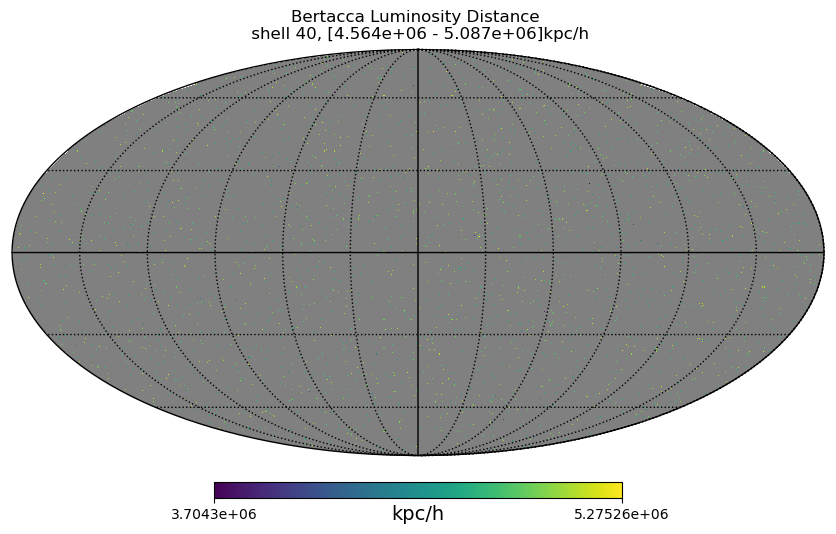

In [10]:
bertacca_map = catalog_selection.bertacca_map(n_side=n_side)
halos_map = catalog_selection.halos_map(n_side=n_side)

masked_map = hp.ma(bertacca_map)
masked_map.mask = bertacca_map == 0

L_D_s = info.from_snapshot_get(snapshot_number, 'xstart') * (1 + info.from_snapshot_get(snapshot_number, 'zstart'))
L_D_e = info.from_snapshot_get(snapshot_number, 'xend') * (1 + info.from_snapshot_get(snapshot_number, 'zend'))
L_D_s = f"{L_D_s:.3e}"
L_D_e = f"{L_D_e:.3e}"

hp.mollview(masked_map, title=f"Bertacca Luminosity Distance \n shell 40, [{L_D_s} - {L_D_e}]kpc/h", unit="kpc/h")
hp.graticule()
plt.show()

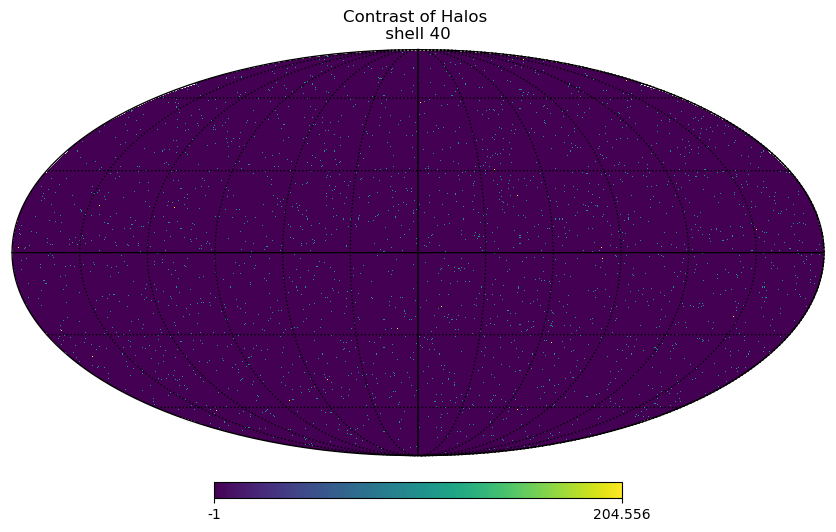

In [11]:
mean_halo_count = np.mean(halos_map)
halo_contrast = (halos_map - mean_halo_count) / mean_halo_count
hp.mollview(halo_contrast, title="Contrast of Halos \n shell 40 ", unit="")
hp.graticule()
plt.show()